<a href="https://colab.research.google.com/github/Linhkobe/Prediction-of-Used-Car-Prices-with-Gradient-Boosting-Regressor/blob/main/script_gbr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 0: Download data from Kaggle

In [ ]:
!pip install kaggle

In [1]:
import os
from google.colab import files

uploaded = files.upload()
os.environ["KAGGLE_CONFIG_DIR"] = "C:\\Users\\admin\\OneDrive\\Documents"

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c playground-series-s4e9

 77% 6.00M/7.84M [00:00<00:00, 61.5MB/s]
100% 7.84M/7.84M [00:00<00:00, 64.1MB/s]


In [5]:
import zipfile
import pandas as pd

with zipfile.ZipFile("playground-series-s4e9.zip", "r") as zip_reg:
    zip_reg.extractall("playground-series-s4e9")

# Step 1: Read data

## 1) Training data

In [1]:
import pandas as pd
pd.set_option("display.max_columns",200)
train_data = pd.read_csv("playground-series-s4e9/train.csv")
train_data.head(20)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


In [2]:
# Shape of training data
train_data.shape

(188533, 13)

## 2) Testing data

In [3]:
test_data = pd.read_csv("playground-series-s4e9/test.csv")
test_data.head(20)

,id,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
1,188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,8-Speed A/T,Silver,Black,None reported,Yes
2,188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,NaN
3,188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,NaN
4,188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes
5,188538,Chevrolet,Express 2500 Work Van,2013,99524,Gasoline,285.0HP 4.8L 8 Cylinder Engine Gasoline Fuel,A/T,Black,Black,None reported,Yes
6,188539,Lexus,RX 350 Base,2008,194000,Gasoline,270.0HP 3.5L V6 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Silver,Gray,None reported,Yes
7,188540,Chevrolet,Impala 1LT,2019,40208,Gasoline,3.8L V6 24V GDI DOHC,6-Speed Automatic,Silver Ice Metallic,Jet Black,None reported,Yes
8,188541,Mercedes-Benz,S-Class S 63 AMG,2016,7600,Gasoline,536.0HP 5.5L 8 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Black,None reported,Yes
9,188542,Genesis,G80 3.3T Sport,2017,63300,Gasoline,365.0HP 3.3L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes


In [4]:
# Shape of testing data
test_data.shape

(125690, 12)

# Step 2: EDA

## 1) Distributions and outliers of numerical variables

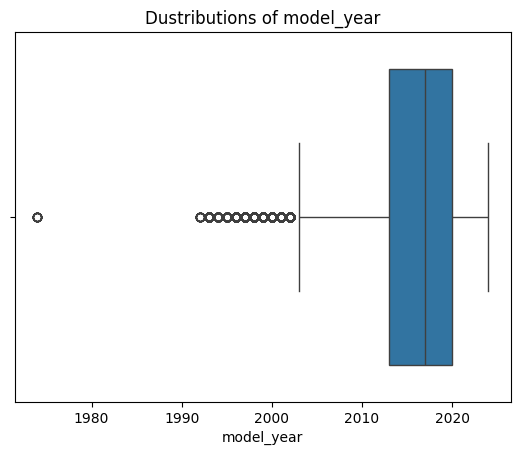

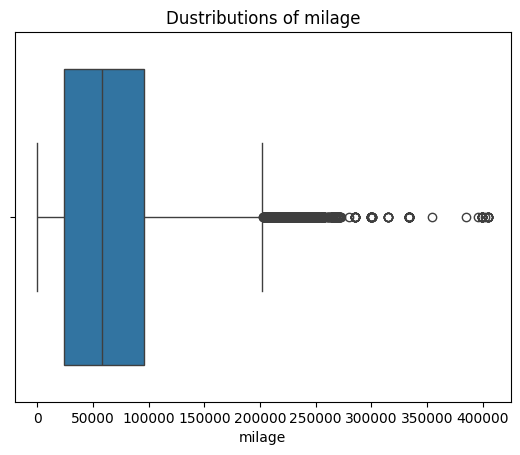

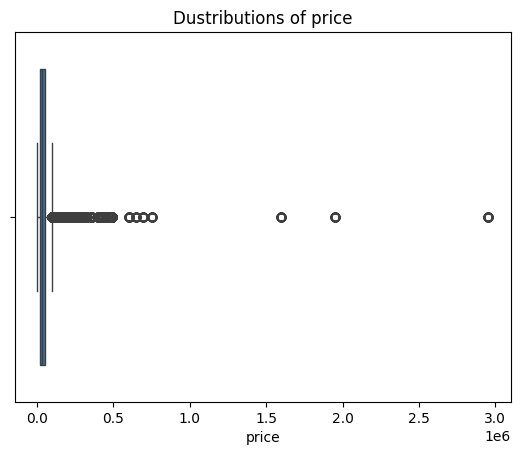

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

for i in train_data.select_dtypes(include = ["number"]).columns:
  if i == "id":
    continue
  sns.boxplot(data = train_data, x = i)
  plt.title(f"Dustributions of {i}")
  plt.show()

## 2) Distribution of target variable

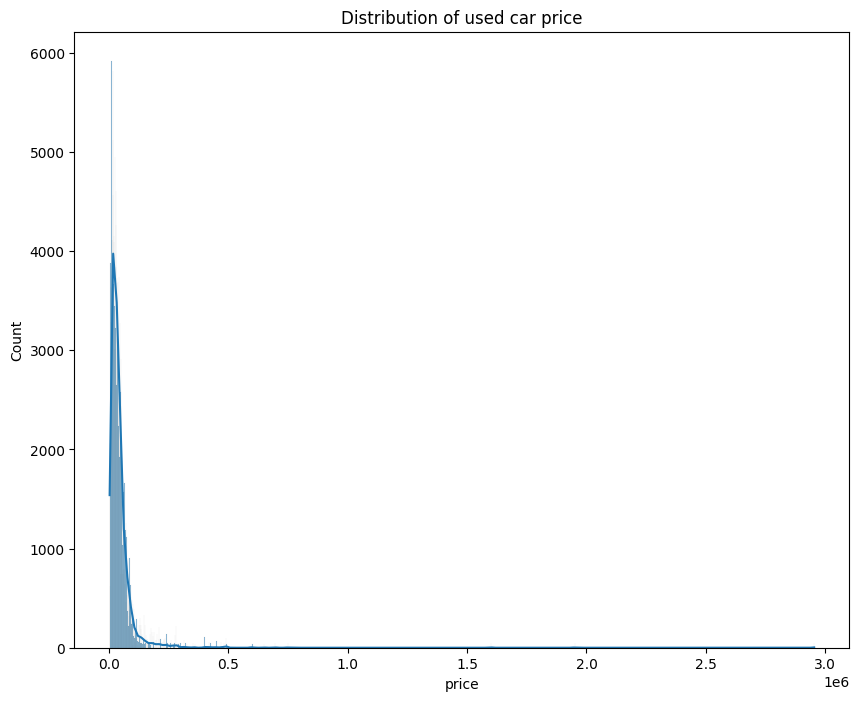

In [6]:
plt.figure(figsize = (10,8))
sns.histplot(data = train_data["price"], kde = True)
plt.title("Distribution of used car price")
plt.show()

### Based on the distribution plot, we can see that it is extremely skewed right due to the outliers so we need to treat these outliers in the step of cleaning data

# 3) Categorical variables

In [7]:
# train_data
cat_cols_train = train_data.select_dtypes(include = ["object", "category"]).columns

dict_cat_cols_train = {col: train_data[col].nunique() for col in cat_cols_train}

for i, value in dict_cat_cols_train.items():
  print(f"Column {i} has {value} unique values")

Column brand has 57 unique values
Column model has 1897 unique values
Column fuel_type has 7 unique values
Column engine has 1117 unique values
Column transmission has 52 unique values
Column ext_col has 319 unique values
Column int_col has 156 unique values
Column accident has 2 unique values
Column clean_title has 1 unique values


In [8]:
# test_data
cat_cols_test = test_data.select_dtypes(include = ["object", "category"]).columns

dict_cat_cols_test = {col: test_data[col].nunique() for col in cat_cols_test}

for i, value in dict_cat_cols_test.items():
  print(f"Column {i} has {value} unique values")

Column brand has 55 unique values
Column model has 1891 unique values
Column fuel_type has 7 unique values
Column engine has 1117 unique values
Column transmission has 52 unique values
Column ext_col has 317 unique values
Column int_col has 156 unique values
Column accident has 2 unique values
Column clean_title has 1 unique values


In [9]:
train_data.drop(columns = ["id"]).nunique().sort_values(ascending = False)

,0
milage,6651
model,1897
price,1569
engine,1117
ext_col,319
int_col,156
brand,57
transmission,52
model_year,34
fuel_type,7


In [10]:
test_data.drop(columns = ["id"]).nunique().sort_values(ascending = False)

,0
milage,5700
model,1891
engine,1117
ext_col,317
int_col,156
brand,55
transmission,52
model_year,36
fuel_type,7
accident,2


### As we can see, the categorical variables in this case have high number of unique values so it won't be a good idea to plot the graph for each one of them normally. Instead, we will plot top n categories. Also the column "clean_title" has just one unique value, this won't be useful for our future machine learning model to learn so we will drop this column later before building the model.

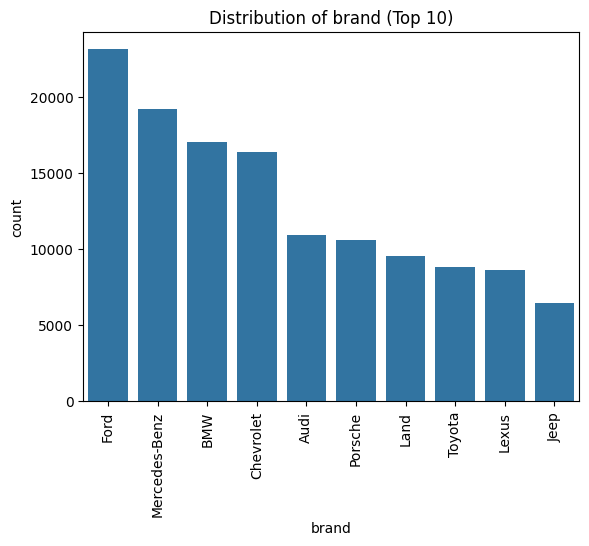

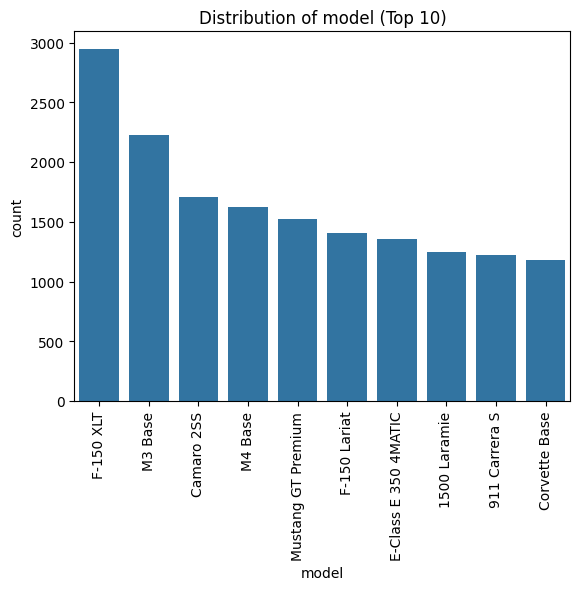

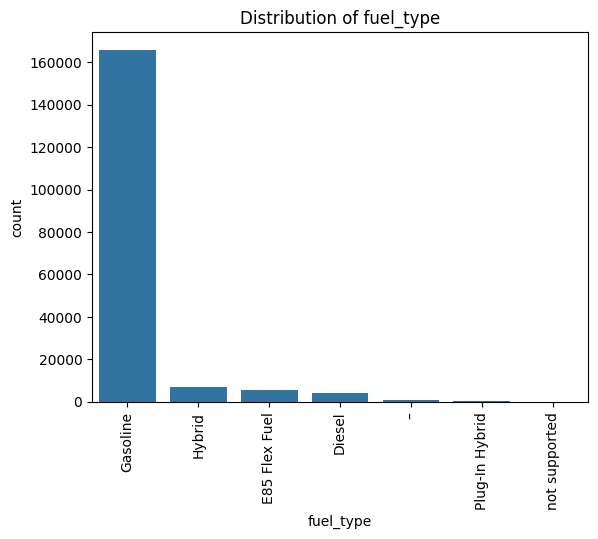

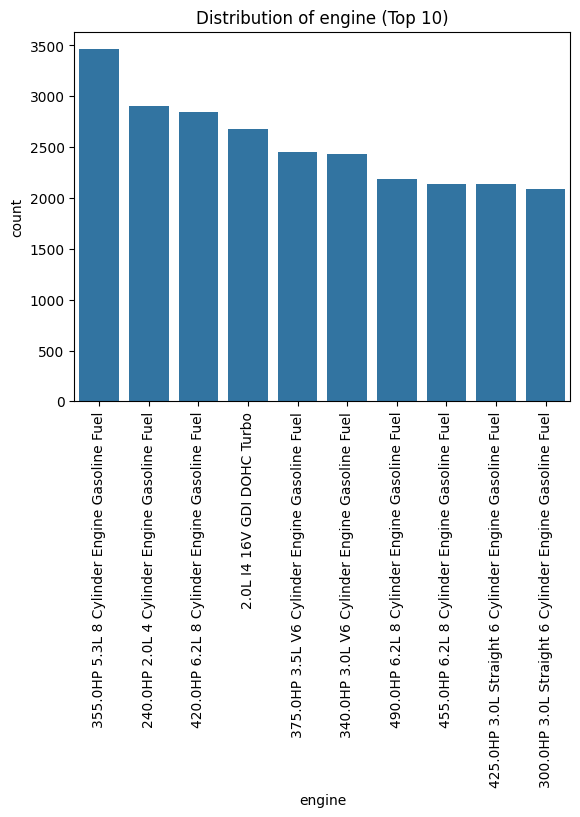

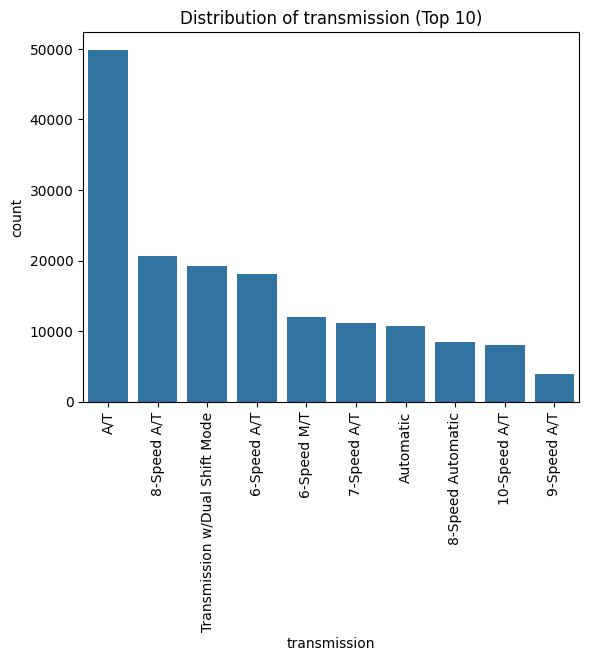

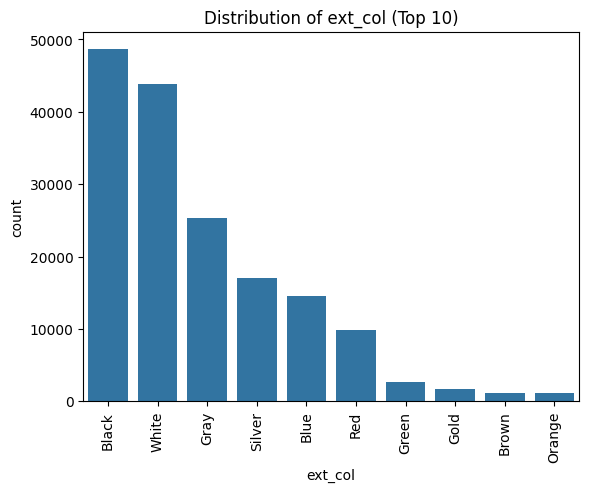

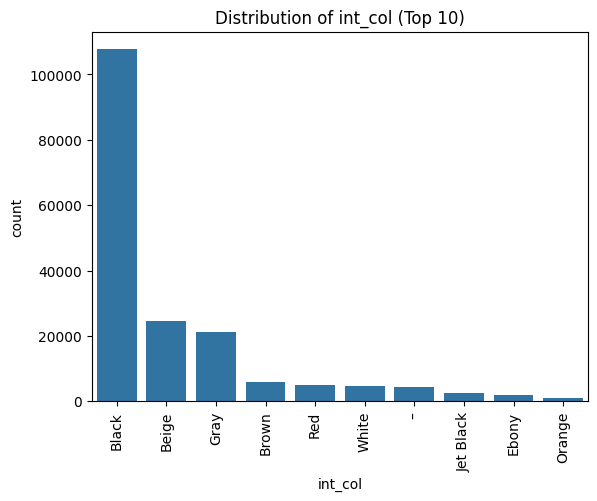

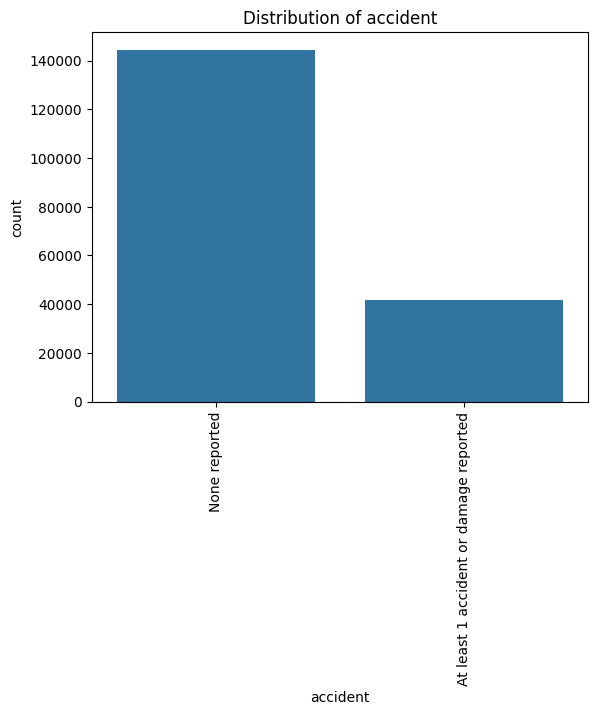

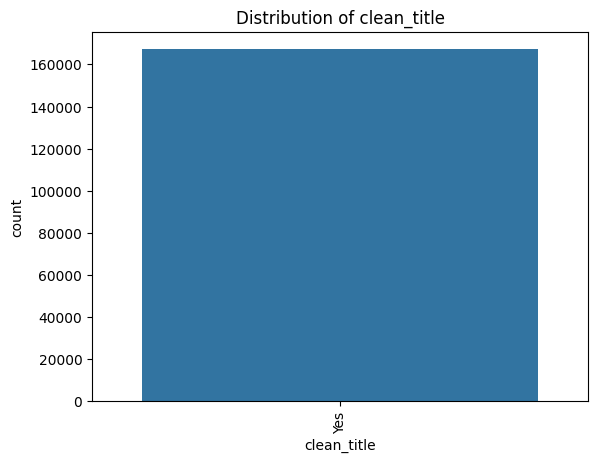

In [11]:
top_n = 10

for col in cat_cols_train:
    if col == "id" and col == "clean_title":
        continue
    if dict_cat_cols_train[col] > top_n:
        top_categories = train_data[col].value_counts().nlargest(top_n).index

        filtered_data = train_data[train_data[col].isin(top_categories)]
    else:
        filtered_data = train_data

    sns.countplot(data = filtered_data, x = col, order = filtered_data[col].value_counts().index)
    plt.title(f"Distribution of {col} (Top {top_n})" if dict_cat_cols_train[col] > top_n else f"Distribution of {col}")
    plt.xticks(rotation = 90)
    plt.show()

## 4) Relationship between numeric variables

<Figure size 1000x800 with 0 Axes>

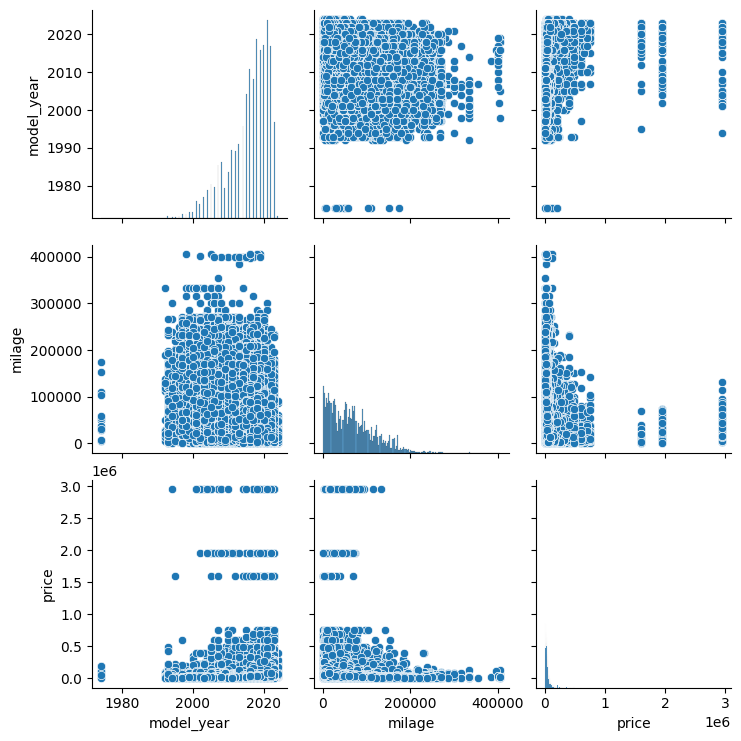

In [12]:
plt.figure(figsize = (10,8))
sns.pairplot(train_data.drop(columns = ["id", "clean_title"]))
plt.show()

## 5) Correlation matrix

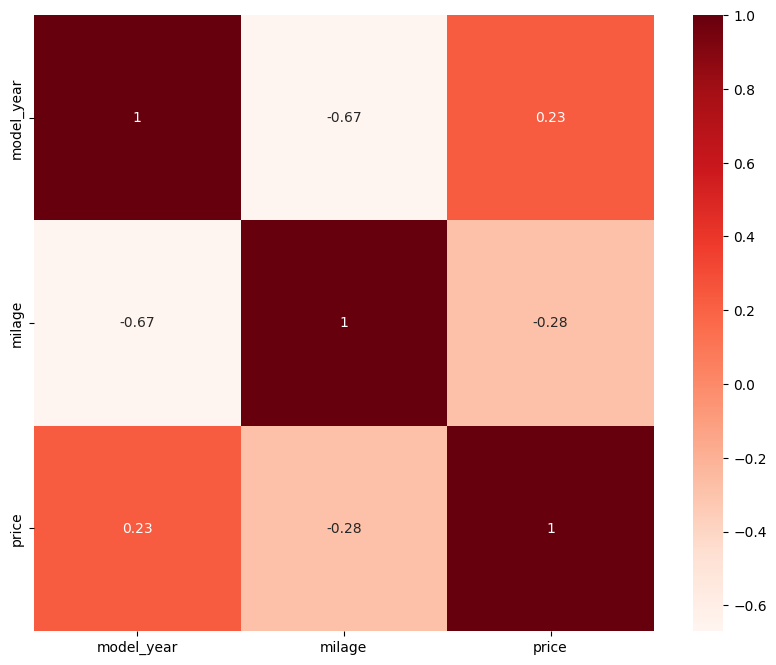

In [13]:
plt.figure(figsize = (10,8))
numeric_corr = train_data.drop(columns = ["id", "clean_title"]).select_dtypes(include = ["number"])
corr = numeric_corr.corr()
sns.heatmap(corr, cmap = "Reds", annot = True)
plt.show()

## 6) Missing and duplicated values

In [14]:
# Missing values in train_data
missing_values_train = train_data.isnull().sum().to_dict()

# Missing values in test_data
missing_values_test = test_data.isnull().sum().to_dict()

# Get columns with missing values > 0 in train_data
filtered_missing_values_train = {key: value for key, value in missing_values_train.items() if value > 0}

# Get columns with missing values > 0 in test_data
filtered_missing_values_test = {key: value for key, value in missing_values_test.items() if value > 0}

print("Dictionary of columns with missing values > 0 in train_data:\n\n", filtered_missing_values_train, "\n")
print("Dictionary of columns with missing values > 0 in test_data:\n\n", filtered_missing_values_test)

Dictionary of columns with missing values > 0 in train_data:

 {'fuel_type': 5083, 'accident': 2452, 'clean_title': 21419} 

Dictionary of columns with missing values > 0 in test_data:

 {'fuel_type': 3383, 'accident': 1632, 'clean_title': 14239}


In [15]:
# Missing values in percentage of train_data

filtered_dict_train_df = train_data[filtered_missing_values_train.keys()]
miss_perc_train = (filtered_dict_train_df.isnull().sum()/train_data.shape[0]*100).sort_values(ascending = True)
miss_perc_train

,0
accident,1.300568
fuel_type,2.696080
clean_title,11.360876


In [16]:
# Missing values in percentage of test_data

filtered_dict_test_df = train_data[filtered_missing_values_test.keys()]
miss_perc_train = (filtered_dict_test_df.isnull().sum()/test_data.shape[0]*100).sort_values(ascending = True)
miss_perc_train

,0
accident,1.950831
fuel_type,4.044077
clean_title,17.041133


### List of numerical variables, categorical variables from above dictionaries

In [17]:
# For train_data
fill_na_num_col_train = []
fill_na_cat_col_train = []

for key, value in filtered_missing_values_train.items():
    if pd.api.types.is_numeric_dtype(train_data[key]):
        fill_na_num_col_train.append(key)
    elif pd.api.types.is_object_dtype(train_data[key]) or pd.api.types.is_categorical_dtype(train_data[key]):
        fill_na_cat_col_train.append(key)

print("List of numerical columns with missing values for train_data:\n\n", fill_na_num_col_train,"\n")
print("List of categorical columns with missing values for train_data:\n\n", fill_na_cat_col_train)

List of numerical columns with missing values for train_data:

 [] 

List of categorical columns with missing values for train_data:

 ['fuel_type', 'accident', 'clean_title']


In [18]:
# For test_data
fill_na_num_col_test = []
fill_na_cat_col_test = []

for key, value in filtered_missing_values_test.items():
    if pd.api.types.is_numeric_dtype(test_data[key]):
        fill_na_num_col_test.append(key)
    elif pd.api.types.is_object_dtype(test_data[key]) or pd.api.types.is_categorical_dtype(test_data[key]):
        fill_na_cat_col_test.append(key)

print("List of numerical columns with missing values for train_data:\n\n", fill_na_num_col_test,"\n")
print("List of categorical columns with missing values for test_data:\n\n", fill_na_cat_col_test)

List of numerical columns with missing values for train_data:

 [] 

List of categorical columns with missing values for test_data:

 ['fuel_type', 'accident', 'clean_title']


In [19]:
# Duplicated values

duplicated_train = train_data.duplicated().sum()
duplicated_test = test_data.duplicated().sum()
print("Duplicated values in train_data:\n\n", duplicated_train, "\n")
print("Duplicated values in test_data:\n\n", duplicated_test)

Duplicated values in train_data:

 0 

Duplicated values in test_data:

 0


# Step 3: Clean data

In [20]:
# Drop id column for train_data et test_data
train_data = train_data.drop(columns = ["id"])
test_data = test_data.drop(columns = ["id"])

In [21]:
train_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title',
       'price'],
      dtype='object')

In [22]:
test_data.columns

Index(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine',
       'transmission', 'ext_col', 'int_col', 'accident', 'clean_title'],
      dtype='object')

In [ ]:
!pip install scikit-learn

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy = "most_frequent")
train_data[['fuel_type', 'accident', 'clean_title']] = imputer.fit_transform(train_data[['fuel_type', 'accident', 'clean_title']])


In [24]:
test_data[['fuel_type', 'accident', 'clean_title']] = imputer.fit_transform(test_data[['fuel_type', 'accident', 'clean_title']])

In [25]:
print(f'Missing Values: {test_data.isna().sum().sum()}')
print(f'Duplicated Values:{test_data.duplicated().sum()}')

Missing Values: 0
Duplicated Values:135


In [26]:
print(f'Missing Values: {train_data.isna().sum().sum()}')
print(f'Duplicated Values:{train_data.duplicated().sum()}')

Missing Values: 0
Duplicated Values:9


## 1) Function to fill missing values based on data type

In [23]:
def fill_missing_values(dataframe):
    for i in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[i]):
            dataframe[i].fillna(dataframe[i].mean(), inplace = True)

        # Fill missing values for categorical variables columns with most frequent value
        elif pd.api.types.is_object_dtype(dataframe[i]) or pd.api.types.is_categorical_dtype(dataframe[i]):
            dataframe[i].fillna(dataframe[i].mode()[0], inplace = True)

## 2) Call above function to fill missing values and drop duplicated values in train_data and test_data

In [27]:
import warnings
warnings.filterwarnings("ignore")
fill_missing_values(test_data)
fill_missing_values(train_data)

train_data = train_data.drop_duplicates()

import numpy as np

# Identify duplicated rows
duplicated_rows_test = test_data[test_data.duplicated(keep=False)]

# Add small random noise to numerical columns to remove exact duplicates
for col in test_data.select_dtypes(include=[np.number]).columns:
    noise = np.random.normal(0, 1e-5, size=duplicated_rows_test.shape[0])
    test_data.loc[duplicated_rows_test.index, col] += noise

## 3) Check missing and duplicated values again for both train_data and test_data

In [28]:
if train_data.isnull().sum().sum() == 0 and test_data.isnull().sum().sum() == 0:
    print("There are no missing values in both train_data and test_data")
else:
    print("There are still missing values in both train_data and test_data")

There are no missing values in both train_data and test_data


In [29]:
if train_data.duplicated().sum() == 0 and test_data.duplicated().sum() == 0:
    print("There are no duplicated values in both train_data and test_data")
else:
    print("There are still duplicated values in both train_data and test_data")

There are no duplicated values in both train_data and test_data


# Step 4: Prepare data for modeling

## 1) Data encoding

In [30]:
from sklearn.preprocessing import LabelEncoder
for col in train_data.columns:
    if train_data[col].dtype == "object":
        le = LabelEncoder()
        train_data[col] = le.fit_transform(train_data[col])

for col in test_data.columns:
    if test_data[col].dtype == "object":
        le = LabelEncoder()
        test_data[col] = le.fit_transform(test_data[col])

In [31]:
train_data.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,31,495,2007,213000,2,116,38,312,71,1,0,4200
1,28,930,2002,143250,2,366,38,263,10,0,0,4999
2,9,1575,2002,136731,1,640,38,38,71,1,0,13900
3,16,758,2017,19500,2,863,49,29,14,1,0,45000
4,36,1077,2021,7388,2,259,23,29,10,1,0,97500


In [32]:
test_data.head(5)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
0,26,1388,2015.0,98000.0,2,326,16,302,10,1,0
1,26,1375,2020.0,9142.0,3,787,31,261,14,1,0
2,14,636,2022.0,28121.0,2,541,3,302,57,1,0
3,3,182,2016.0,61258.0,2,193,39,259,14,1,0
4,3,181,2018.0,59000.0,2,365,38,127,14,1,0


## 2) Features scaling

In [33]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X = train_data.drop(columns = ["price"])
y = train_data["price"]

X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y.values.reshape(-1,1))

X_test_scaled = X_scaler.transform(test_data)

In [34]:
pd.DataFrame(X_train_scaled).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.553571,0.261076,0.66,0.525809,0.333333,0.103943,0.745098,0.981132,0.458065,1.0,0.0
1,0.500000,0.490506,0.56,0.353544,0.333333,0.327957,0.745098,0.827044,0.064516,0.0,0.0
2,0.160714,0.830696,0.56,0.337444,0.166667,0.573477,0.745098,0.119497,0.458065,1.0,0.0
3,0.285714,0.399789,0.86,0.047913,0.333333,0.773297,0.960784,0.091195,0.090323,1.0,0.0
4,0.642857,0.568038,0.94,0.018000,0.333333,0.232079,0.450980,0.091195,0.064516,1.0,0.0


In [35]:
pd.DataFrame(y_train_scaled).head(5)

,0
0,0.000745
1,0.001016
2,0.004031
3,0.014566
4,0.032350


In [36]:
pd.DataFrame(X_test_scaled).head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,0.464286,0.732068,0.82,0.241788,0.333333,0.292115,0.313725,0.949686,0.064516,1.0,0.0
1,0.464286,0.725211,0.92,0.022331,0.500000,0.705197,0.607843,0.820755,0.090323,1.0,0.0
2,0.250000,0.335443,0.96,0.069205,0.333333,0.484767,0.058824,0.949686,0.367742,1.0,0.0
3,0.053571,0.095992,0.84,0.151045,0.333333,0.172939,0.764706,0.814465,0.090323,1.0,0.0
4,0.053571,0.095464,0.88,0.145468,0.333333,0.327061,0.745098,0.399371,0.090323,1.0,0.0


# Step 5: Building models

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y_train_scaled, test_size = 0.2, random_state = 42)

train_data = pd.concat([pd.DataFrame(X_train), pd.DataFrame(y_train, columns = ["price"] )], axis = 1)

In [37]:
!pip install pycaret

In [38]:
from pycaret.regression import *

reg = setup(data = train_data, target = "price", normalize = True, session_id = 42)

,Description,Value
0,Session id,42
1,Target,price
2,Target type,Regression
3,Original data shape,"(150819, 12)"
4,Transformed data shape,"(150819, 12)"
5,Transformed train set shape,"(105573, 12)"
6,Transformed test set shape,"(45246, 12)"
7,Numeric features,11
8,Preprocess,True
9,Imputation type,simple


In [39]:
# Best models
best_models = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.0067,0.0006,0.0243,0.1486,0.0194,0.7146,12.1440
lightgbm,Light Gradient Boosting Machine,0.0067,0.0006,0.0244,0.1456,0.0195,0.6948,2.5110
ridge,Ridge Regression,0.0078,0.0006,0.0249,0.1066,0.0200,1.0132,0.1010
lar,Least Angle Regression,0.0078,0.0006,0.0249,0.1066,0.0200,1.0132,0.1580
br,Bayesian Ridge,0.0078,0.0006,0.0249,0.1066,0.0200,1.0125,0.1120
lr,Linear Regression,0.0078,0.0006,0.0249,0.1066,0.0200,1.0132,0.6900
omp,Orthogonal Matching Pursuit,0.0083,0.0006,0.0252,0.0862,0.0203,1.1462,0.1520
huber,Huber Regressor,0.0067,0.0007,0.0253,0.0760,0.0205,0.6453,0.3870
xgboost,Extreme Gradient Boosting,0.0070,0.0007,0.0255,0.0591,0.0206,0.7107,1.1040
rf,Random Forest Regressor,0.0074,0.0007,0.0259,0.0316,0.0210,0.7499,64.1750


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [40]:
# The best chosen model
best_models

GradientBoostingRegressor(random_state=42)

In [41]:
# Tune the best model
tuned_best_models = tune_model(best_models)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0067,0.0007,0.0270,0.1079,0.0208,0.7195
1,0.0067,0.0007,0.0261,0.1524,0.0208,0.6857
2,0.0065,0.0005,0.0226,0.1755,0.0183,0.6792
3,0.0066,0.0007,0.0257,0.1342,0.0201,0.7036
4,0.0067,0.0006,0.0250,0.1350,0.0199,0.6965
5,0.0065,0.0004,0.0199,0.1929,0.0167,0.7155
6,0.0062,0.0003,0.0173,0.2351,0.0151,0.6735
7,0.0069,0.0008,0.0287,0.1197,0.0221,0.7127
8,0.0067,0.0006,0.0248,0.1407,0.0199,0.7032


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [42]:
pd.DataFrame(X_test_scaled).shape

(125690, 11)

In [43]:
# Evaluate the best model
evaluate_model(best_models)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# Step 6: Making predictions

In [44]:
# Using final model to make predictions from testing data (train_test_split)
y_pred = predict_model(tuned_best_models, data = pd.DataFrame(X_test))
y_pred

,0,1,2,3,4,5,6,7,8,9,10,prediction_label
0,0.767857,0.228903,0.76,0.189923,0.333333,0.361111,0.392157,0.091195,0.200000,1.0,0.0,0.006736
1,0.482143,0.417722,0.92,0.055238,0.333333,0.519713,0.960784,0.091195,0.090323,1.0,0.0,0.019269
2,0.250000,0.336498,0.88,0.228978,0.333333,0.672939,0.039216,0.119497,0.090323,1.0,0.0,0.010875
3,0.160714,0.268460,0.98,0.036799,0.333333,0.738351,0.745098,0.402516,0.761290,1.0,0.0,0.027433
4,0.767857,0.626055,0.76,0.156582,0.333333,0.508065,0.960784,0.402516,0.090323,1.0,0.0,0.008062
...,...,...,...,...,...,...,...,...,...,...,...,...
37700,0.017857,0.721519,0.92,0.057394,0.333333,0.180108,0.627451,0.764151,0.090323,1.0,0.0,0.014435
37701,0.303571,0.308544,0.68,0.394912,0.333333,0.089606,0.745098,0.091195,0.090323,0.0,0.0,0.001769
37702,0.250000,0.342827,0.92,0.086202,0.333333,0.183692,0.333333,0.735849,0.367742,1.0,0.0,0.012657
37703,0.250000,0.591772,0.90,0.087429,0.333333,0.821685,0.039216,0.402516,0.090323,1.0,0.0,0.015431


In [45]:
y_pred.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       'prediction_label'],
      dtype='object')

In [46]:
# Inverse transform the predicted price
predicted_price_1 = y_scaler.inverse_transform(y_pred["prediction_label"].values.reshape(-1,1))

# Compare the predicted prices with the actual prices
actual_price = y_scaler.inverse_transform(y_test)

In [47]:
from sklearn.metrics import mean_squared_error
import numpy as np
mse = mean_squared_error(actual_price, predicted_price_1)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % np.sqrt(mse))

MSE: 5706109954.88
RMSE: 75538.80


In [48]:
# Using final model to make predictions from testing data of the competition
y_pred_test = predict_model(tuned_best_models, data = pd.DataFrame(X_test_scaled))
y_pred_test

,0,1,2,3,4,5,6,7,8,9,10,prediction_label
0,0.464286,0.732068,0.82,0.241788,0.333333,0.292115,0.313726,0.949686,0.064516,1.0,0.0,0.005356
1,0.464286,0.725211,0.92,0.022331,0.500000,0.705197,0.607843,0.820755,0.090323,1.0,0.0,0.026164
2,0.250000,0.335443,0.96,0.069205,0.333333,0.484767,0.058824,0.949686,0.367742,1.0,0.0,0.016951
3,0.053571,0.095992,0.84,0.151045,0.333333,0.172939,0.764706,0.814465,0.090323,1.0,0.0,0.006878
4,0.053571,0.095464,0.88,0.145468,0.333333,0.327061,0.745098,0.399371,0.090323,1.0,0.0,0.009186
...,...,...,...,...,...,...,...,...,...,...,...,...
125685,0.642857,0.400316,0.80,0.205520,0.333333,0.655914,0.450980,0.091195,0.090323,1.0,0.0,0.008185
125686,0.053571,0.658228,0.90,0.072205,0.333333,0.457885,0.764706,0.949686,0.090323,1.0,0.0,0.014868
125687,0.053571,0.097046,0.76,0.191489,0.333333,0.603047,0.745098,0.091195,0.090323,1.0,0.0,0.006948
125688,0.053571,0.656118,0.76,0.276365,0.333333,0.603047,0.745098,0.091195,0.090323,1.0,0.0,0.005073


In [49]:
# Inverse transform the predicted price
y_pred_scaled = y_pred_test["prediction_label"]
y_pred_submission = y_scaler.inverse_transform(y_pred_scaled.values.reshape(-1,1))
y_pred_submission

array([[17812.06633473],
       [79237.7929982 ],
       [52042.21355522],
       ...,
       [22511.97855494],
       [16975.90163358],
       [34418.7682878 ]])

# Step 7: Submission

In [50]:
data_submission_gbr = pd.DataFrame({
    "id" : range(188533, 188533 + len(y_pred_submission)),
    "class": y_pred_submission.flatten()
})

data_submission_gbr.to_csv("data_submission_gbr.csv", index = False)

print("Data for submission is exported successfully")

Data for submission is exported successfully


In [51]:
data_submission_gbr.shape

(125690, 2)